In [8]:
# 导包
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import defaultdict

In [9]:
# 求出训练集中购买精品的用户集合
def qualityUser():
    orderFutureTrain = pd.read_csv('./data/orderFuture_train.csv')
    userAndType = orderFutureTrain[['userid','orderType']].values
    userWithQ = set() 
    for line in userAndType: 
        if line[1] == 1: userWithQ.add(str(line[0]))
    
    return userWithQ

userWithQ = qualityUser()
print(len(userWithQ))

6625


In [10]:
# action visualization
action_train = pd.read_csv('./data/action_train.csv')
print(action_train.head(5))

actions = action_train[['userid', 'actionTime', 'actionType']].values
user_map = defaultdict(list)

for action in actions:
    userid = str(action[0])
    actionTime = action[1]
    actionType = action[2]
#     if (5 <= actionType <= 9): actionType = 0
#     else: actionType = 1
    user_map[userid].append((actionTime, actionType))
    
# 用户数
print(len(user_map))  

         userid  actionType  actionTime
0  100000000013           1  1474300753
1  100000000013           5  1474300763
2  100000000013           6  1474300874
3  100000000013           5  1474300911
4  100000000013           6  1474300936
40307


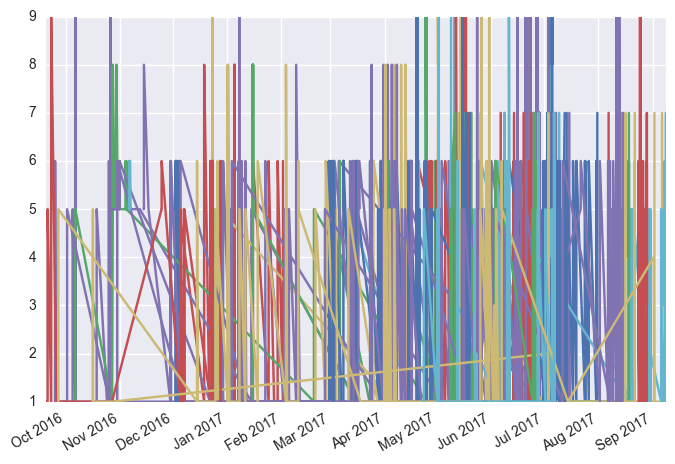

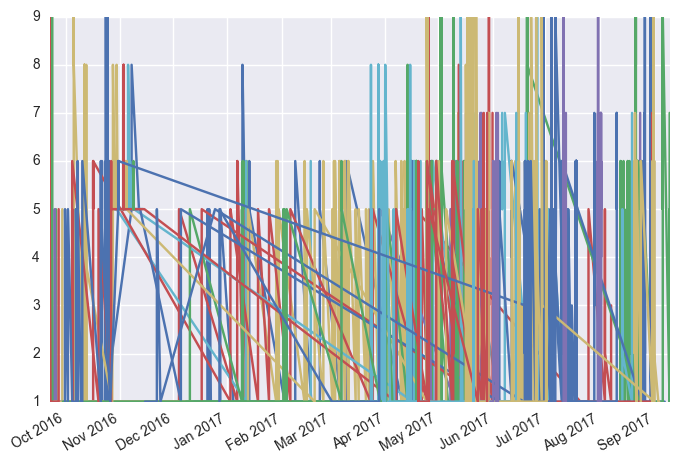

In [15]:
# 画出某个用户在时序上的购买行为
def plotSingleUser(user_map, user):
    x = []
    y = []
    for line in user_map[user]:
        x.append(line[0])
        y.append(line[1])
    ts = pd.Series(y, index = pd.to_datetime(x, unit = 's'))
    ts.plot()

plt.figure()
count = 0
for user in userWithQ:
    count += 1
    if (count % 100 == 0): plotSingleUser(user_map, user)
plt.show()

plt.figure()
count2 = 0
for user in user_map:
    if (user not in userWithQ):
        count2 += 1
    if (count2 % 600 == 0): plotSingleUser(user_map, user)

plt.show()

In [11]:
from collections import defaultdict
# 得到每个用户在多个Action上的点击次数及操作总次数，1 2 3 4 5 6 7 8 9 1-9 表示各个操作次数，10 表示操作总次数
def totalAction(fileName):
    df = pd.read_csv(fileName)
    datas = df[['userid','actionType']].values
    actionMap = defaultdict()
    for data in datas:
        user = str(data[0])
        action  = int(data[1])
        if user not in actionMap:
            actionMap[user] = [0] * 10
        actionMap[user][0] += 1
        actionMap[user][action] += 1
    return actionMap

actionMap = totalAction('./data/action_train.csv')
print(len(actionMap))

def generateAcrionFeature(actionMap, fileName = './data/train.csv'):
    df = pd.read_csv(fileName)
    users = df['userid'].values
    features = []
    for user in users:
        user = str(user)
        if user not in actionMap:
            features.append([0] * 10)
        else:
            features.append(actionMap[user])
    
    colMap = {}
    for i in range(1, 10):
        key = 'feature' + str(i)
        colMap[key] = [(feature[i] / feature[0])for feature in features]
    ndf = pd.DataFrame(colMap)
    return colMap, ndf

colMap, actionFeature = generateAcrionFeature(actionMap)
actionFeature.head(5)

train = pd.read_csv('./data/train.csv')
columns = [key for key in colMap.keys()]
# columns.append('feature10')
train = train.drop(columns, axis = 1).join(actionFeature)
train.head(5)
# 本地化
train.to_csv('./data/train.csv', index = False)
print('persist done...')

40307
persist done...


In [12]:
# 测试集
actionMapForTest = totalAction('./data/test/action_test.csv')
print(len(actionMapForTest))
colMap, actionFeature = generateAcrionFeature(actionMapForTest, './data/test/test.csv')
actionFeature.head(5)

columns = [key for key in colMap.keys()]
#columns.append('feature10')

test = pd.read_csv('./data/test/test.csv')
test = test.drop(columns, axis = 1).join(actionFeature)
test.head(5)

test.to_csv('./data/test/test.csv', index = False)
print('persist done...')

10076
persist done...


In [13]:
# 训练集 得到9中行为转换的平均交易间隔
def getSequenceMap(fileName):
    df = pd.read_csv(fileName)
    datas = df[['userid', 'actionType', 'actionTime']].values
    sequenceMap = defaultdict(list)
    for data in datas:
        user = str(data[0])
        actionType = int(data[1])
        actionTime = int(data[2])
        sequenceMap[user].append((actionType, actionTime))
    return sequenceMap

sequenceMap = getSequenceMap('./data/action_train.csv')
print(len(sequenceMap))

def actionTimeGapMap(sequenceMap):
    actionTimeGapCntMap = {}
    actionTimeGapAvgMap = {}
    totalActionMap = defaultdict(int)
    for key in sequenceMap.keys():
        sequence = sequenceMap[key]
        actionTimeGapCntMap[key] = [[0] * 9 for j in range(9)]  # 防止除零错误
        actionTimeGapAvgMap[key] = [[0] * 9 for j in range(9)]
        totalActionMap[key] = 0
        for i in range(len(sequence) - 1):
            nowAction = sequence[i + 1][0] - 1
            prvAction = sequence[i][0] - 1
            
            nowTime = sequence[i + 1][1]
            prvTime = sequence[i][1]
            
            actionTimeGapCntMap[key][prvAction][nowAction] += 1
            actionTimeGapAvgMap[key][prvAction][nowAction] += nowTime - prvTime
            totalActionMap[key] += 1
            
        for i in range(9):
            for j in range(9):
                if actionTimeGapCntMap[key][i][j] == 0:
                    actionTimeGapAvgMap[key][i][j] = 0x3f3f3f3f
                else: 
                    actionTimeGapAvgMap[key][i][j] /= actionTimeGapCntMap[key][i][j]
    return actionTimeGapCntMap, actionTimeGapAvgMap, totalActionMap

actionTimeGapCntMap, actionTimeGapAvgMap, totalActionMap = actionTimeGapMap(sequenceMap)
# cnt = 0
# for key in totalActionMap.keys():
#     if totalActionMap[key] == 0:
#         cnt += 1
#         print(key)
# print(cnt)
def generateActionTransFeature(actionTimeGapCntMap, totalActionMap, fileName):
    df = pd.read_csv(fileName)
    users = df[['userid']].values
    features = []
    for user in users:
        user = str(user[0])
        if totalActionMap[user] == 0 or user not in actionTimeGapCntMap:
            features.append([[0] * 9 for j in range(9)])
        else:
            val = [[0] * 9 for j in range(9)]
            for i in range(9):
                for j in range(9):
                    val[i][j] = actionTimeGapCntMap[user][i][j] / totalActionMap[user]
            features.append(val)
    colMap = {}
    for i in range(81):
        row = int(i / 9)
        col = i % 9
        key = 'actionTrans' + str(i + 1)
        colMap[key] = [feature[row][col] for feature in features]
    ndf = pd.DataFrame(colMap)
    return colMap, ndf
    
colMap, actionTransFeature = generateActionTransFeature(actionTimeGapCntMap, totalActionMap, './data/train.csv')
actionTransFeature.head(5)
columns = [key for key in colMap.keys()]
train = pd.read_csv('./data/train.csv')
train = train.drop(columns, axis = 1).join(actionTransFeature)
train.head(5)
# 本地化
train.to_csv('./data/train.csv', index = False)
print('persist done...')

40307
persist done...


In [14]:
# 测试集
sequenceMapForTest = getSequenceMap('./data/test/action_test.csv')
print(len(sequenceMapForTest))

actionTimeGapCntMapForTest, actionTimeGapAvgMapForTest, totalActionMapForTest = actionTimeGapMap(sequenceMapForTest)
colMap, actionTransFeatureForTest = generateActionTransFeature(actionTimeGapCntMapForTest, totalActionMapForTest, './data/test/test.csv')
actionTransFeatureForTest.head(5)
columns = [key for key in colMap.keys()]
test = pd.read_csv('./data/test/test.csv')
test = test.drop(columns, axis = 1).join(actionTransFeatureForTest)
print(test.head(5))

test.to_csv('./data/test/test.csv', index = False)
print('persist done...')

10076
         userid  total     ratio    timeTrans1   timeTrans10   timeTrans11  \
0  100000000371      1  0.000000  1.061110e+09  1.061110e+09  1.061110e+09   
1  100000001215      0  0.000000  3.728090e+05  1.061110e+09  1.061110e+09   
2  100000001445      5  0.000000  1.362779e+05  1.061110e+09  1.061110e+09   
3  100000001575      3  0.333333  5.912550e+05  1.061110e+09  1.061110e+09   
4  100000001601      0  0.000000  3.436838e+05  1.061110e+09  1.061110e+09   

    timeTrans12   timeTrans13   timeTrans14   timeTrans15      ...       \
0  1.061110e+09  1.061110e+09  1.061110e+09  1.061110e+09      ...        
1  1.061110e+09  1.061110e+09  1.061110e+09  1.061110e+09      ...        
2  1.061110e+09  1.061110e+09  1.061110e+09  1.061110e+09      ...        
3  1.061110e+09  1.061110e+09  1.061110e+09  1.061110e+09      ...        
4  1.061110e+09  1.061110e+09  1.061110e+09  1.061110e+09      ...        

   actionTrans74  actionTrans75  actionTrans76  actionTrans77  actionTrans

In [16]:
# 训练集 每个动作之间的平均游览间隔
def generateTimeTransFeature(actionTimeGapAvgMap, fileName):
    df = pd.read_csv(fileName)
    users = df[['userid']].values
    features = []
    for user in users:
        user = str(user[0])
        if user not in actionTimeGapAvgMap:
            features.append([0x3f3f3f3f] * 9 for j in range(9))
        else:
            features.append(actionTimeGapAvgMap[user])
    
    colMap = {}
    for i in range(81):
        row = int(i / 9)
        col = i % 9
        key = 'timeTrans' + str(i + 1)
        colMap[key] = [feature[row][col] for feature in features]
    ndf = pd.DataFrame(colMap)
    return colMap, ndf  
    
colMap, timeTransFeature = generateTimeTransFeature(actionTimeGapAvgMap, './data/train.csv')
timeTransFeature.head(5)

columns = [key for key in colMap.keys()]

train = pd.read_csv('./data/train.csv')
train = train.drop(columns, axis = 1).join(timeTransFeature)
train.head(5)
# 本地化
train.to_csv('./data/train.csv', index = False)
print('persist done...')

In [18]:
# 测试集 每个动作之间的平均游览间隔
sequenceMapForTest = getSequenceMap('./data/test/action_test.csv')
print(len(sequenceMapForTest))

actionTimeGapCntMapForTest, actionTimeGapAvgMapForTest, totalActionMapForTest = actionTimeGapMap(sequenceMapForTest)
colMap, timeTransFeatureForTest = generateTimeTransFeature(actionTimeGapAvgMapForTest, './data/test/test.csv')
timeTransFeatureForTest.head(5)

columns = [key for key in colMap.keys()]

test = pd.read_csv('./data/test/test.csv')
test = test.drop(columns, axis = 1).join(timeTransFeatureForTest)
print(test.head(5))

test.to_csv('./data/test/test.csv', index = False)

10076
         userid  total     ratio  province    gender  feature1  feature2  \
0  100000000371      1  0.000000  0.182480  0.194200  0.076923       0.0   
1  100000001215      0  0.000000  0.148909  0.194200  0.407407       0.0   
2  100000001445      5  0.000000  0.137720  0.171008  0.477011       0.0   
3  100000001575      3  0.333333  0.148240  0.194200  0.226190       0.0   
4  100000001601      0  0.000000  0.182480  0.194200  0.466667       0.0   

   feature3  feature4  feature5      ...        timeTrans74   timeTrans75  \
0  0.000000       0.0  0.461538      ...       1.061110e+09  1.061110e+09   
1  0.000000       0.0  0.518519      ...       1.061110e+09  1.061110e+09   
2  0.000000       0.0  0.379310      ...       1.061110e+09  1.061110e+09   
3  0.000000       0.0  0.500000      ...       1.061110e+09  1.061110e+09   
4  0.066667       0.0  0.066667      ...       1.061110e+09  1.061110e+09   

    timeTrans76   timeTrans77   timeTrans78   timeTrans79    timeTrans8  \